In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#set display defaults
plt.rcParams['figure.figsize'] = (10,10) #large images
plt.rcParams['image.interpolation'] = 'nearest' #don't interpolate, show square pixels
plt.rcParams['image.cmap']='gray'

In [3]:
import sys
caffe_root = '/home/asad/workspace/triNNity-caffe/'
sys.path.insert(0,caffe_root+'python')

import caffe

In [4]:
import os
if os.path.isfile(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print('CaffeNet found')
else:
    print('Downloading pre-trained CaffeNet model...')
    !~/workspace/triNNity-caffe/scripts/download_model_binary.py ~/workspace/triNNity-caffe/models/bvlc_reference_caffenet
        

CaffeNet found


In [5]:
caffe.set_mode_cpu()

model_def = caffe_root+'models/bvlc_reference_caffenet/deploy.prototxt'
model_weights = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

net = caffe.Net(model_def, # defines the structure of the model
               model_weights, # contains the trained weights,
               caffe.TEST) # use test mode (e.g., don't perform dropout)

In [6]:
#import caffe

def shai_net_to_py_readable(prototxt_filename, caffemodel_filename):
  net = caffe.Net(prototxt_filename, caffemodel_filename, caffe.TEST) # read the net + weights
  pynet_ = [] 
  for li in xrange(len(net.layers)):  # for each layer in the net
    layer = {}  # store layer's information
    layer['name'] = net._layer_names[li]
    # for each input to the layer (aka "bottom") store its name and shape
    layer['bottoms'] = [(net._blob_names[bi], net.blobs[net._blob_names[bi]].data.shape) 
                         for bi in list(net._bottom_ids(li))] 
    # for each output of the layer (aka "top") store its name and shape
    layer['tops'] = [(net._blob_names[bi], net.blobs[net._blob_names[bi]].data.shape) 
                      for bi in list(net._top_ids(li))]
    layer['type'] = net.layers[li].type  # type of the layer
    # the internal parameters of the layer. not all layers has weights.
    layer['weights'] = [net.layers[li].blobs[bi].data[...] 
                        for bi in xrange(len(net.layers[li].blobs))]
    pynet_.append(layer)
  return pynet_

In [103]:
# load the mean ImageNet image ( as distributed by Caffe) for subtraction
mu = np.load(caffe_root+'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1) #average over pixels to obtain the mean (BGR) pixel values
print('mean-subtracted values:{}'.format(set(zip('BGR', mu)))) # to print zip values, need to convert to set

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data',(2,0,1)) # move image channels to outermost dimension
transformer.set_mean('data',mu) #subtract the dataset-mean value in each channel
#transformer.set_raw_scale('data',255) #rescale from [0,1] to [0,255] (image is being read using cv2 that reads in an image in teh range [0,255])
transformer.set_channel_swap('data',(2,1,0)) # swap channels from RGB to BGR

mean-subtracted values:{('B', 104.0069879317889), ('R', 122.6789143406786), ('G', 116.66876761696767)}


In [104]:
# set the size of the input
net.blobs['data'].reshape(50, #batch size
                         3, # 3-channel BGR images
                         227,227) # image size is 227x227

(3, 227, 227)


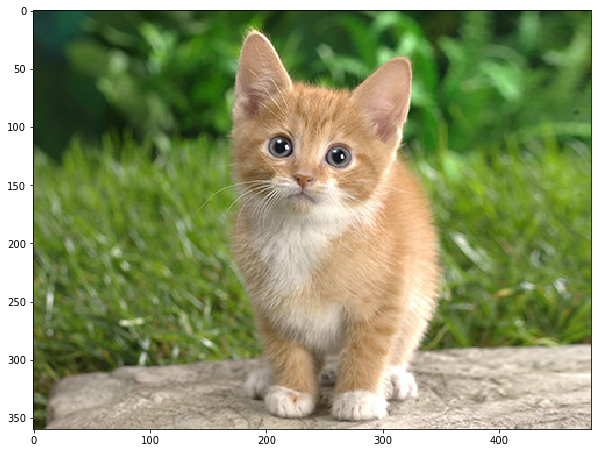

In [105]:
import cv2
image = cv2.imread(caffe_root + 'examples/images/cat.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) #converting from BGR to RGB
transformed_image = transformer.preprocess('data',image)
plt.imshow(image)
print(transformed_image.shape)

In [106]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

# perform classficiation
output = net.forward()

output_prob = output['prob'][0] # the output probability for the first image in the batch
print('Predicted class is: {}'.format(output_prob.argmax()))

Predicted class is: 281


In [107]:
# load imagenet labels
labels_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
if not os.path.exists(labels_file):
    !/home/asad/workspace/triNNity-caffe/data/ilsvrc12/get_ilsvrc_aux.sh
    
labels = np.loadtxt(labels_file, str, delimiter='\t')

print('Output label: {}'.format(labels[output_prob.argmax()]))

Output label: n02123045 tabby, tabby cat


In [108]:
# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5] #reverse sort and take five largest items

print('Probabilities and labels: {}'.format(set(zip(output_prob[top_inds], labels[top_inds]))))

Probabilities and labels: {(0.23455316, 'n02123159 tiger cat'), (0.12840912, 'n02124075 Egyptian cat'), (0.32929432, 'n02123045 tabby, tabby cat'), (0.062002342, 'n02127052 lynx, catamount'), (0.103429176, 'n02119022 red fox, Vulpes vulpes')}


In [109]:
for layer_name, blob in net.blobs.items():
    print('Layer_name: {}'.format(layer_name)+'\t {}'.format(blob.data.shape))

Layer_name: data	 (50, 3, 227, 227)
Layer_name: conv1	 (50, 96, 55, 55)
Layer_name: pool1	 (50, 96, 27, 27)
Layer_name: norm1	 (50, 96, 27, 27)
Layer_name: conv2	 (50, 256, 27, 27)
Layer_name: pool2	 (50, 256, 13, 13)
Layer_name: norm2	 (50, 256, 13, 13)
Layer_name: conv3	 (50, 384, 13, 13)
Layer_name: conv4	 (50, 384, 13, 13)
Layer_name: conv5	 (50, 256, 13, 13)
Layer_name: pool5	 (50, 256, 6, 6)
Layer_name: fc6	 (50, 4096)
Layer_name: fc7	 (50, 4096)
Layer_name: fc8	 (50, 1000)
Layer_name: prob	 (50, 1000)


In [110]:
for layer_name, param in net.params.items():
    print('Layer name: {}'.format(layer_name)+'\t {}'.format(param[0].data.shape)+'\t {}'.format(param[1].data.shape))

Layer name: conv1	 (96, 3, 11, 11)	 (96,)
Layer name: conv2	 (256, 48, 5, 5)	 (256,)
Layer name: conv3	 (384, 256, 3, 3)	 (384,)
Layer name: conv4	 (384, 192, 3, 3)	 (384,)
Layer name: conv5	 (256, 192, 3, 3)	 (256,)
Layer name: fc6	 (4096, 9216)	 (4096,)
Layer name: fc7	 (4096, 4096)	 (4096,)
Layer name: fc8	 (1000, 4096)	 (1000,)


In [111]:
def vis_square(data):
    """Take an array of shape (n, height,weight) or (n,height,width,3) and visualize
     each (height,weight) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data-data.min())/(data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n**2 - data.shape[0]),
               (0,1),(0,1)) # add some space between filters
              +((0,0),) * (data.ndim-3)) # don't pad the last dimension (if there is one)
    
    data = np.pad(data, padding, mode='constant', constant_values=1) #pad with ones (white)
    
    #tile the filters into an image
    data = data.reshape((n,n) + data.shape[1:]).transpose((0,2,1,3)+tuple(range(4,data.ndim+1)))
    data = data.reshape((n*data.shape[1], n*data.shape[3])+data.shape[4:])
    
    plt.imshow(data);
    plt.axis('off')

In [112]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
d = filters.transpose(0,2,3,1)
print(d.shape)
print(d.shape[0])
d = (d-d.min())/(d.max()-d.min())
n = int(np.ceil(np.sqrt(d.shape[0])))
print(n)

(96, 11, 11, 3)
96
10


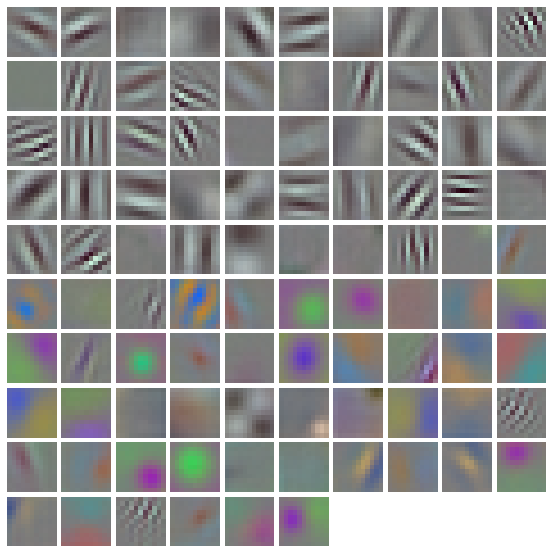

In [113]:
vis_square(filters.transpose(0,2,3,1))

(50, 96, 55, 55)
(96, 55, 55)


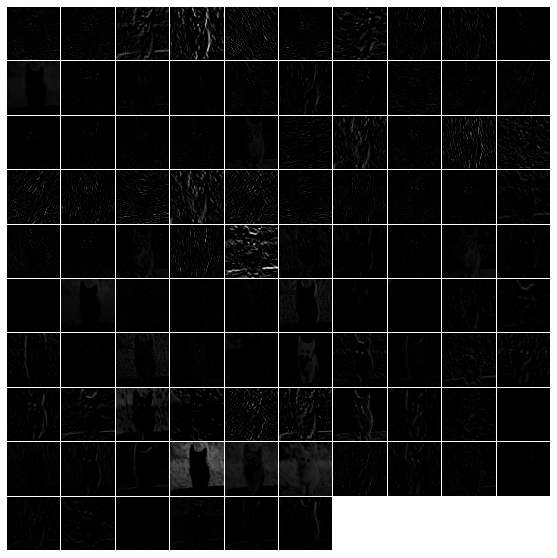

In [114]:
feat = net.blobs['conv1'].data[2, :96]
print(net.blobs['conv1'].data.shape)
print(feat.shape)
vis_square(feat)

float32


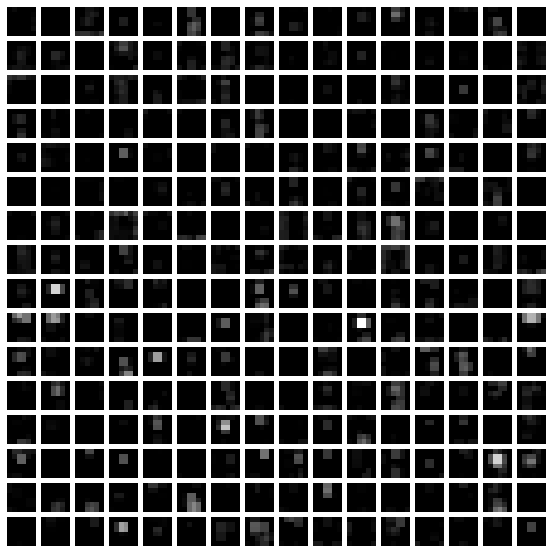

In [115]:
feat = net.blobs['pool5'].data[0]
print(feat.dtype)
vis_square(feat)

(4096,)


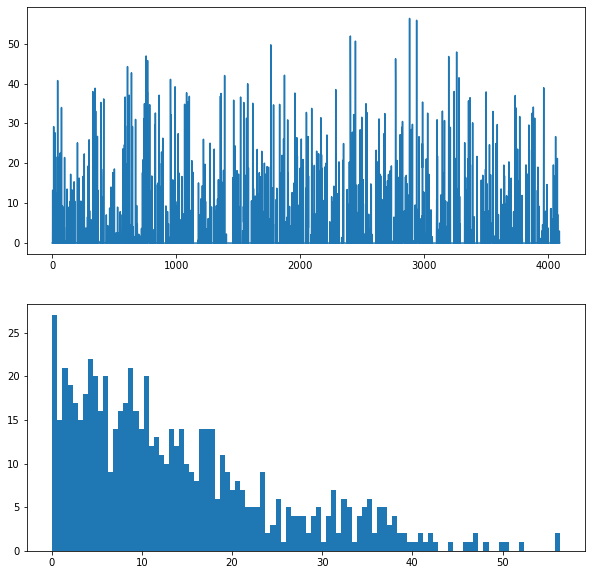

In [116]:
feat = net.blobs['fc6'].data[0]
print(feat.shape)
plt.subplot(2,1,1)
plt.plot(feat.flat) # no need of flat as feat already one dimension
plt.subplot(2,1,2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

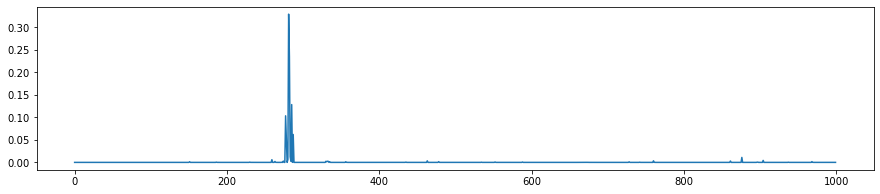

In [117]:
feat = net.blobs['prob'].data[0]
plt.figure(figsize=(15,3))
plt.plot(feat.flat)

In [129]:
my_image_url = "https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG"
!wget -O image.jpg $my_image_url

image = cv2.imread('image.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) #converting from BGR to RGB
net.blobs['data'].data[...] = transformer.preprocess('data',image)



--2020-01-14 12:34:33--  https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving upload.wikimedia.org (upload.wikimedia.org)... 2620:0:862:ed1a::2:b, 91.198.174.208
Connecting to upload.wikimedia.org (upload.wikimedia.org)|2620:0:862:ed1a::2:b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443340 (1.4M) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]   1.38M  --.-KB/s    in 0.1s    

2020-01-14 12:34:33 (9.96 MB/s) - ‘image.jpg’ saved [1443340/1443340]



[365 379 380 381 374]
int64
Probabilites and labels: {(0.00040328625, 'n02493509 titi, titi monkey'), (0.00011981835, 'n02493793 spider monkey, Ateles geoffroyi'), (0.031504743, 'n02492660 howler monkey, howler'), (0.9676702, 'n02480495 orangutan, orang, orangutang, Pongo pygmaeus'), (6.4057305e-05, 'n02488291 langur')}
int64
Label : n02480495 orangutan, orang, orangutang, Pongo pygmaeus	Probability : 0.967670202255249


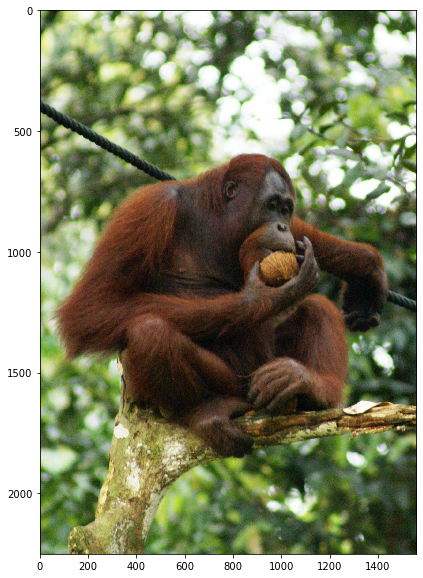

In [143]:
net.forward()

output_prob = net.blobs['prob'].data[0]

top_inds = output_prob.argsort()[::-1][:5]
print(top_inds)
plt.imshow(image)
print(top_inds.dtype)
print('Probabilites and labels: {}'.format(set(zip(output_prob[top_inds], labels[top_inds]))))
top_id = output_prob.argmax()
print(top_id.dtype)
print('Label : {}'.format(labels[top_id])+'\tProbability : {}'.format(output_prob[top_id]))